In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import imageio

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
PIXELS_PER_METER = 420 / 3.7 # approximately

In [8]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

In [9]:
test_images = [lanelines.open_image(f) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [10]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

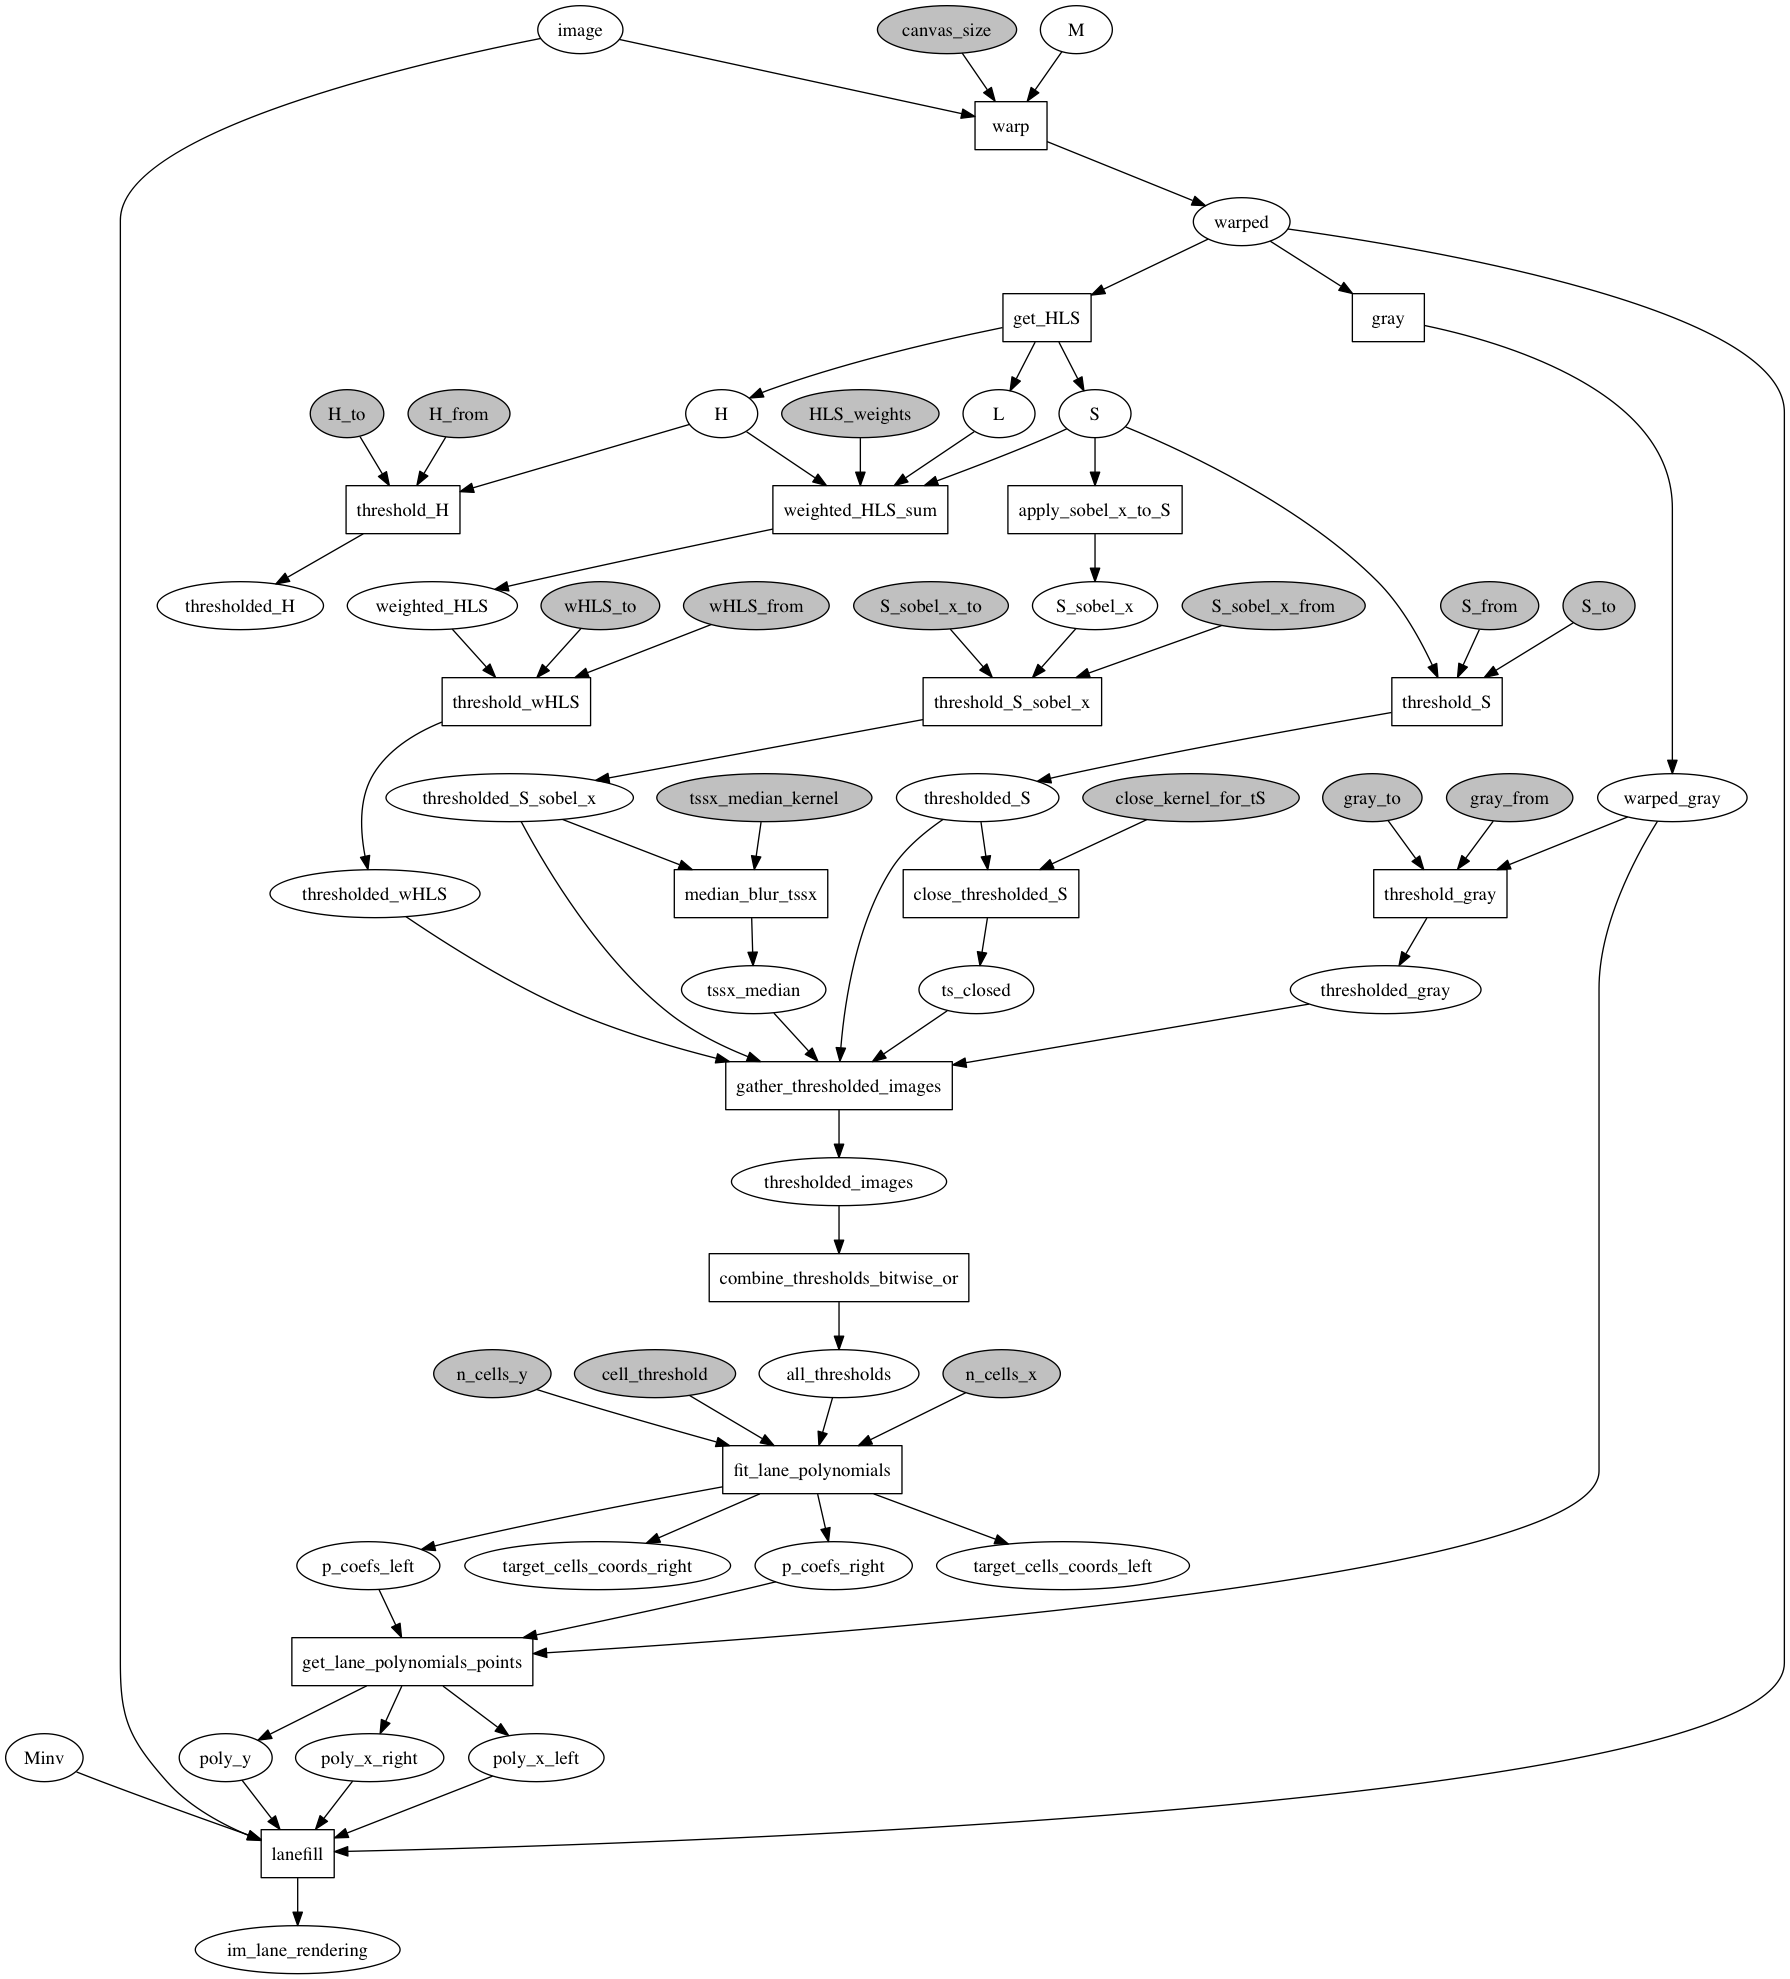

In [22]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
nxpd.draw(runner.token_manager.to_networkx())

In [12]:
def curvature_poly2(params, at_point):
    
    a, b, _ = params
    return ((1 + (2 * a * at_point + b) ** 2) ** 1.5) / np.abs(2 * a)


def lane_center(poly_x_left, poly_x_right, last_n=15):
    return poly_x_left[-last_n:] + (poly_x_right[-last_n:] - poly_x_left[-last_n:])

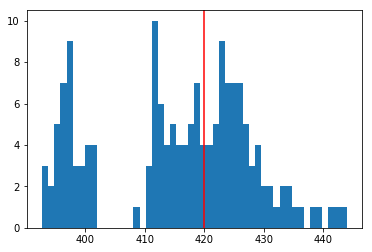

In [13]:
diffs_list = []

for im in test_images_undist:
    
    runner.run(image=im, M=M, Minv=Minv)
    diffs = lane_center(runner['poly_x_left'], runner['poly_x_right'], last_n=20)
    diffs_list.append(diffs)
    
all_diffs = np.concatenate(diffs_list)

_ = plt.hist(all_diffs, bins=50)
plt.axvline(420, color='r')

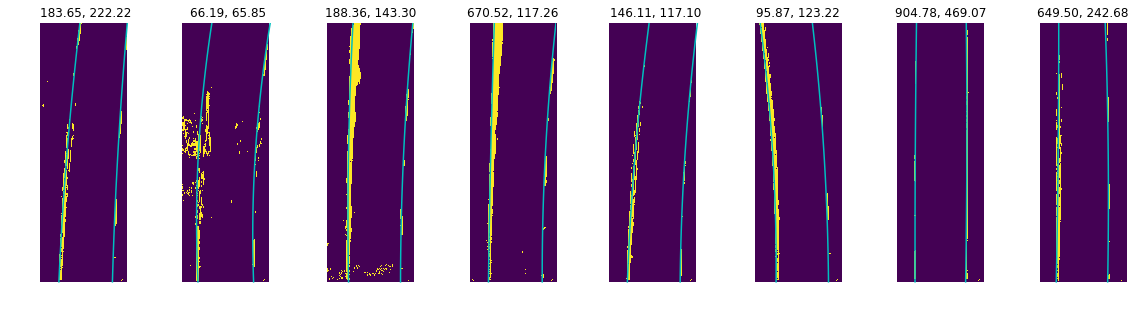

In [14]:
last_y = CANVAS_SZ[1]

plt.figure(figsize=(20, 5))

for i, im in enumerate(test_images_undist):
    runner.run(image=im, M=M, Minv=Minv)
    
    plt.subplot(1, 8, i+1)
    plt.imshow( runner['all_thresholds'])
    _ = plt.axis('off')
    
    plt.plot(runner['poly_x_left'], runner['poly_y'], color='c')
    plt.plot(runner['poly_x_right'], runner['poly_y'], color='c')
    
    curv_left = curvature_poly2(runner['p_coefs_left'], last_y)
    curv_right = curvature_poly2(runner['p_coefs_right'], last_y)
    
    plt.title('{:.2f}, {:.2f}'.format(curv_left / PIXELS_PER_METER, curv_right / PIXELS_PER_METER))

In [17]:
video_rd = imageio.get_reader('project_video.mp4')

In [35]:
all_p_coefs_left = []
all_p_coefs_right = []

for frame in video_rd:
    
    runner.run(image=frame, M=M, Minv=Minv)
    
    all_p_coefs_left.append(runner['p_coefs_left'])
    all_p_coefs_right.append(runner['p_coefs_right'])
    
all_p_coefs_left = np.array(all_p_coefs_left)
all_p_coefs_right = np.array(all_p_coefs_right)

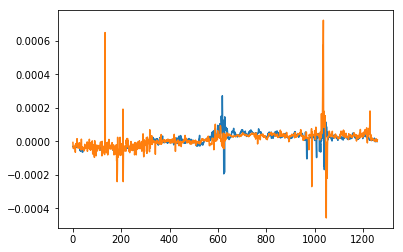

In [36]:
plt.plot(all_p_coefs_left[:, 0])
plt.plot(all_p_coefs_right[:, 0])

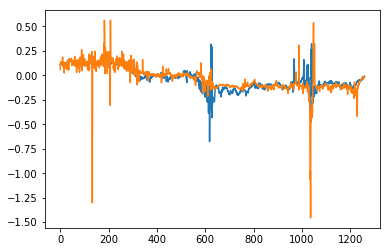

In [37]:
plt.plot(all_p_coefs_left[:, 1])
plt.plot(all_p_coefs_right[:, 1])

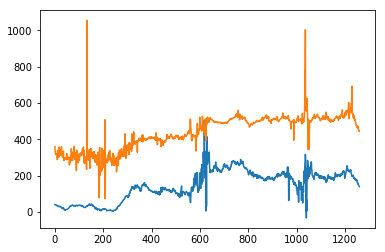

In [38]:
plt.plot(all_p_coefs_left[:, 2])
plt.plot(all_p_coefs_right[:, 2])

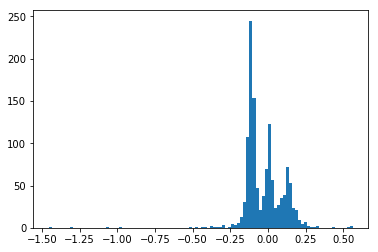

In [41]:
_ = plt.hist(all_p_coefs_right[:, 1], bins=100)

In [103]:
class Smoother(object):
    
    def __init__(self, runner, M, Minv, token_names):
        self._runner = runner
        self._token_names = token_names
        self._M = M
        self._Minv = Minv
        
        self._last = {tk: None for tk in token_names}
        self._diff = {tk: None for tk in token_names}
    
    def __call__(self, im, diff_ratio_threshold=50.):
        
        res = {}
        
        self._runner.run(image=im, M=self._M, Minv=self._Minv)
        
        for tk in self._token_names:            
            val = runner[tk]

            if self._last[tk] is None: # the first point
                #print('first')
                self._last[tk] = val
                res[tk] = val
                continue
                
            smoothed = 0.5 * (val + self._last[tk])
            diff = smoothed - self._last[tk]
            
            
            if self._diff[tk] is not None: # 3rd point and onwards

                diff_ratio = diff / self._diff[tk]
                
                if np.linalg.norm(diff_ratio) > diff_ratio_threshold:
                    #print('anomaly')
                    extrapolated = self._last[tk] + self._diff[tk]
                    self._last[tk] = extrapolated
                    res[tk] = extrapolated
                    continue     
            
                    
            #print('ok')
            self._diff[tk] = diff
            self._last[tk] = smoothed
            res[tk] = smoothed
            
        return res


In [112]:
N = 200

smoo = Smoother(runner, M, Minv, ['p_coefs_left', 'p_coefs_right'])

sm_p_coefs_left = []
sm_p_coefs_right = []

for i, frame in enumerate(video_rd):
    
    if i > N:
        break
    
    res = smoo(frame, diff_ratio_threshold=60.)
    
    runner.run(image=frame, M=M, Minv=Minv)
    
    sm_p_coefs_left.append(res['p_coefs_left'])
    sm_p_coefs_right.append(res['p_coefs_right'])
    
sm_p_coefs_left = np.array(sm_p_coefs_left)
sm_p_coefs_right = np.array(sm_p_coefs_right)

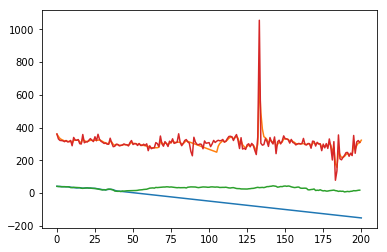

In [113]:
plt.plot(sm_p_coefs_left[:, 2])
plt.plot(sm_p_coefs_right[:, 2])

plt.plot(all_p_coefs_left[:N, 2])
plt.plot(all_p_coefs_right[:N, 2])

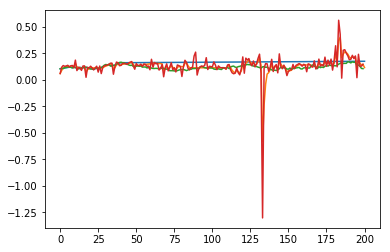

In [116]:
plt.plot(sm_p_coefs_left[:, 1])
plt.plot(sm_p_coefs_right[:, 1])

plt.plot(all_p_coefs_left[:N, 1])
plt.plot(all_p_coefs_right[:N, 1])